# **Toxic Comments Classification**

This notebook attempts to build a machine learning model capable of classifying whether or not a comment is toxic and predict the probability of each type of toxicity.

**Problem Definition**

In an online environment, the comment section of any social media is very fragile these days. The threat of abuse and harassment online will negate the main purpose of social media, which is to exchange information and have healthy relationships with other people. Social media allows you to connect with friends and family, learn new things, develop interests and have fun. Many people stop expressing themselves and give up on seeking different opinions due to online abuse and harassment. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The aim of this project is to build a model that is capable of detecting different types of toxicity like threat, obscenity, insult, and identity-based hate. With the model built, hopefully it will represented as a baseline solution to a more productive and respectful online discussion.

**Data Source**

The data is downloaded from the [*Jigsaw Toxic Comments Classification Challenge*](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview/description) hosted on Kaggle.

There are 3 main datasets:
1. `train_csv` is the training set, contains comments with their binary labels.
2. `test_csv` is the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.
3. `test_labels.csv` is the labels for the test set, with the value of -1 indicates it was not used for scoring.

**Evaluation**

The outcome will be evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column.

## Notebook Setup

In [1]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from wordcloud import WordCloud, STOPWORDS
from gensim.utils import tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
warnings.filterwarnings("ignore")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("omw-1.4")
sns.set_style("whitegrid")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Getting the Data

In [4]:
!chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

Done


In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 7.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=c7d22009b5861ace9c85c094a6eb6b32215fdc7eae9488587ec5ae1c98af6330
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge 
!ls

 95% 50.0M/52.6M [00:00<00:00, 83.5MB/s]
100% 52.6M/52.6M [00:00<00:00, 79.8MB/s]
jigsaw-toxic-comment-classification-challenge.zip  sample_data


In [7]:
!mkdir "jigsaw-toxic-comment-classification-challenge"
!unzip "jigsaw-toxic-comment-classification-challenge.zip" -d "jigsaw-toxic-comment-classification-challenge"
!unzip "jigsaw-toxic-comment-classification-challenge/test.csv.zip" -d "jigsaw-toxic-comment-classification-challenge"
!unzip "jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip" -d "jigsaw-toxic-comment-classification-challenge"
!unzip "jigsaw-toxic-comment-classification-challenge/train.csv.zip" -d "jigsaw-toxic-comment-classification-challenge"

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip  
  inflating: jigsaw-toxic-comment-classification-challenge/test.csv.zip  
  inflating: jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip  
  inflating: jigsaw-toxic-comment-classification-challenge/train.csv.zip  
Archive:  jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: jigsaw-toxic-comment-classification-challenge/test.csv  
Archive:  jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: jigsaw-toxic-comment-classification-challenge/test_labels.csv  
Archive:  jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: jigsaw-toxic-comment-classification-challenge/train.csv  


In [8]:
train_df = pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/train.csv", low_memory=False)
test_df = pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/test.csv", low_memory=False)
test_labels_df = pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/test_labels.csv", low_memory=False)

## Data Understanding

In [9]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [11]:
test_labels_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [12]:
print("Shape of train data:", train_df.shape)
print("Shape of test data:", test_df.shape)
print("Shape of test labels data:", test_labels_df.shape)

Shape of train data: (159571, 8)
Shape of test data: (153164, 2)
Shape of test labels data: (153164, 7)


In [13]:
train_df.info(), test_df.info(), test_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163


(None, None, None)

In [14]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.095844,0.294379,0.0,0.0,0.0,0.0,1.0
severe_toxic,159571.0,0.009996,0.099477,0.0,0.0,0.0,0.0,1.0
obscene,159571.0,0.052948,0.223931,0.0,0.0,0.0,0.0,1.0
threat,159571.0,0.002996,0.054650,0.0,0.0,0.0,0.0,1.0
insult,159571.0,0.049364,0.216627,0.0,0.0,0.0,0.0,1.0
identity_hate,159571.0,0.008805,0.093420,0.0,0.0,0.0,0.0,1.0


In [15]:
test_labels_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
toxic,153164.0,-0.542530,0.572465,-1.0,-1.0,-1.0,0.0,1.0
severe_toxic,153164.0,-0.579895,0.498408,-1.0,-1.0,-1.0,0.0,1.0
obscene,153164.0,-0.558193,0.542966,-1.0,-1.0,-1.0,0.0,1.0
threat,153164.0,-0.580913,0.496195,-1.0,-1.0,-1.0,0.0,1.0
insult,153164.0,-0.559916,0.539594,-1.0,-1.0,-1.0,0.0,1.0
identity_hate,153164.0,-0.577642,0.503260,-1.0,-1.0,-1.0,0.0,1.0


In [16]:
train_df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [17]:
test_df.isna().sum()

id              0
comment_text    0
dtype: int64

In [18]:
test_labels_df.isna().sum()

id               0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## Exploratory Data Analysis

In [19]:
labels = list(train_df.columns[2:])
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [20]:
print("Total amount of comments:", len(train_df))
print("Total amount of toxic comments:", train_df.iloc[:, 2:].any(1).sum())
print("Total amount of non-toxic comments:", len(train_df) - train_df.iloc[:, 2:].any(1).sum())

Total amount of comments: 159571
Total amount of toxic comments: 16225
Total amount of non-toxic comments: 143346


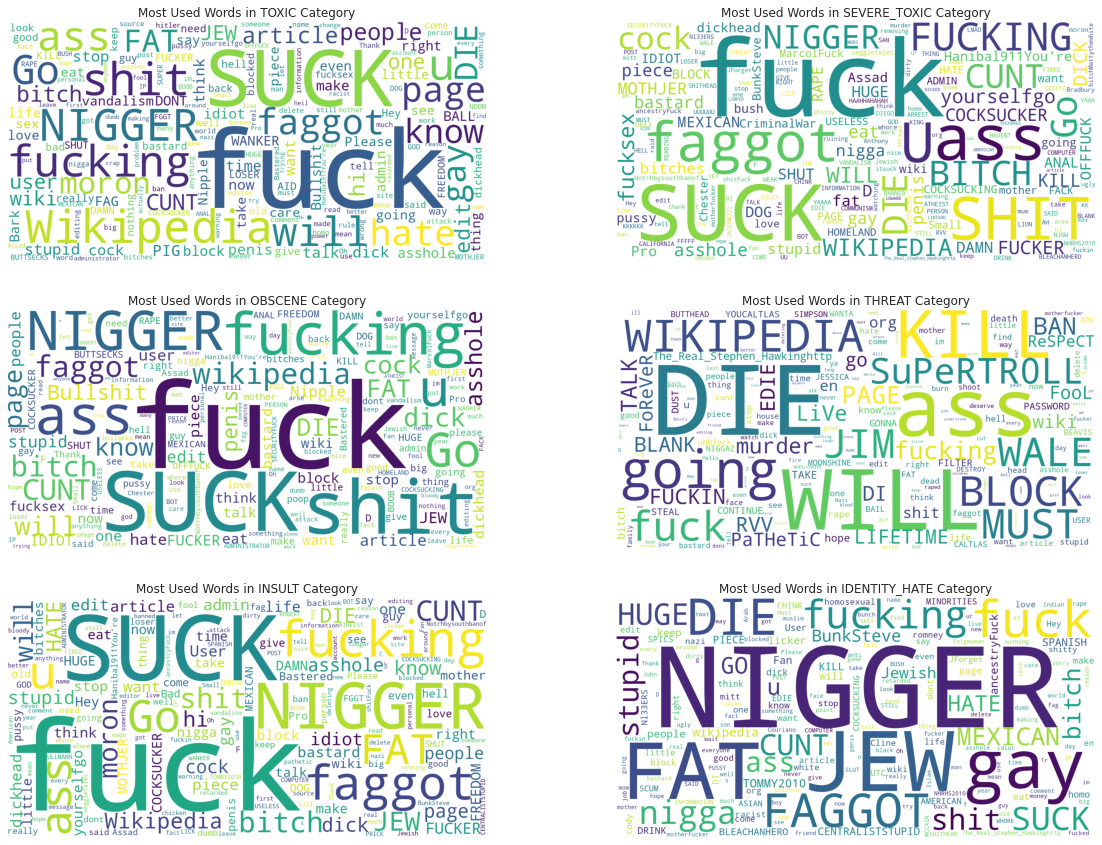

In [21]:
index = 0
fig, axes = plt.subplots(nrows=3,
                         ncols=2,
                         figsize=(20, 15))

axes = axes.flatten()
for label in labels:
  ones = train_df[train_df[label] == 1]
  text = ones["comment_text"].values
  cloud = WordCloud(stopwords=STOPWORDS,
                    collocations=False,
                    background_color="white",
                    width=1500,
                    height=750).generate(" ".join(text))
                    
  axes[index].set_title(f"Most Used Words in {label.upper()} Category")
  axes[index].imshow(cloud)
  axes[index].axis("off")
  index += 1

plt.show()

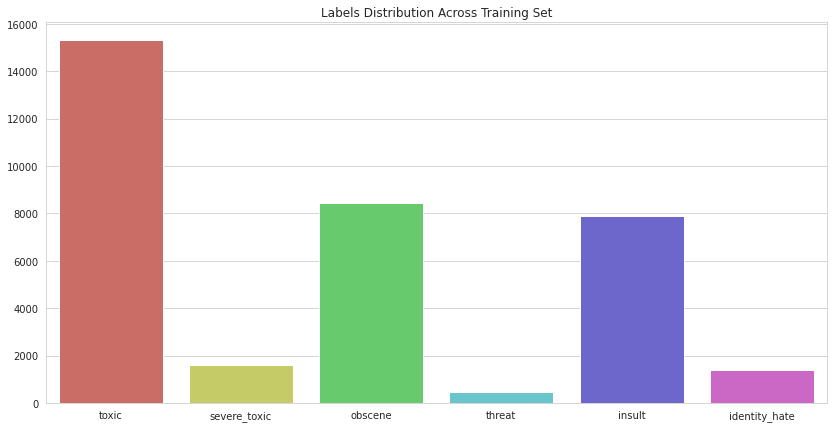

In [22]:
labels_distribution = train_df.iloc[:, 2:].sum()
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x=labels_distribution.index,
            y=labels_distribution.values,
            ax=ax,
            palette="hls").set_title("Labels Distribution Across Training Set")

plt.show()

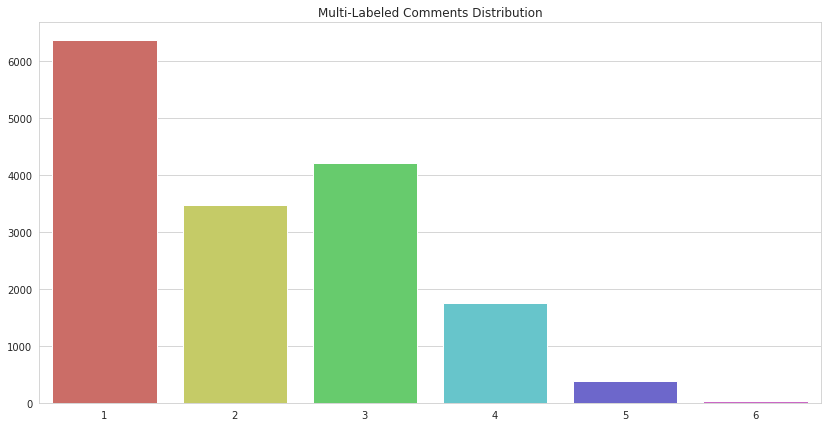

In [23]:
multi_labeled = train_df.iloc[:, 2:].sum(axis=1).value_counts()[1:]
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x=multi_labeled.index,
            y=multi_labeled.values,
            ax=ax,
            palette="hls").set_title("Multi-Labeled Comments Distribution")

plt.show()

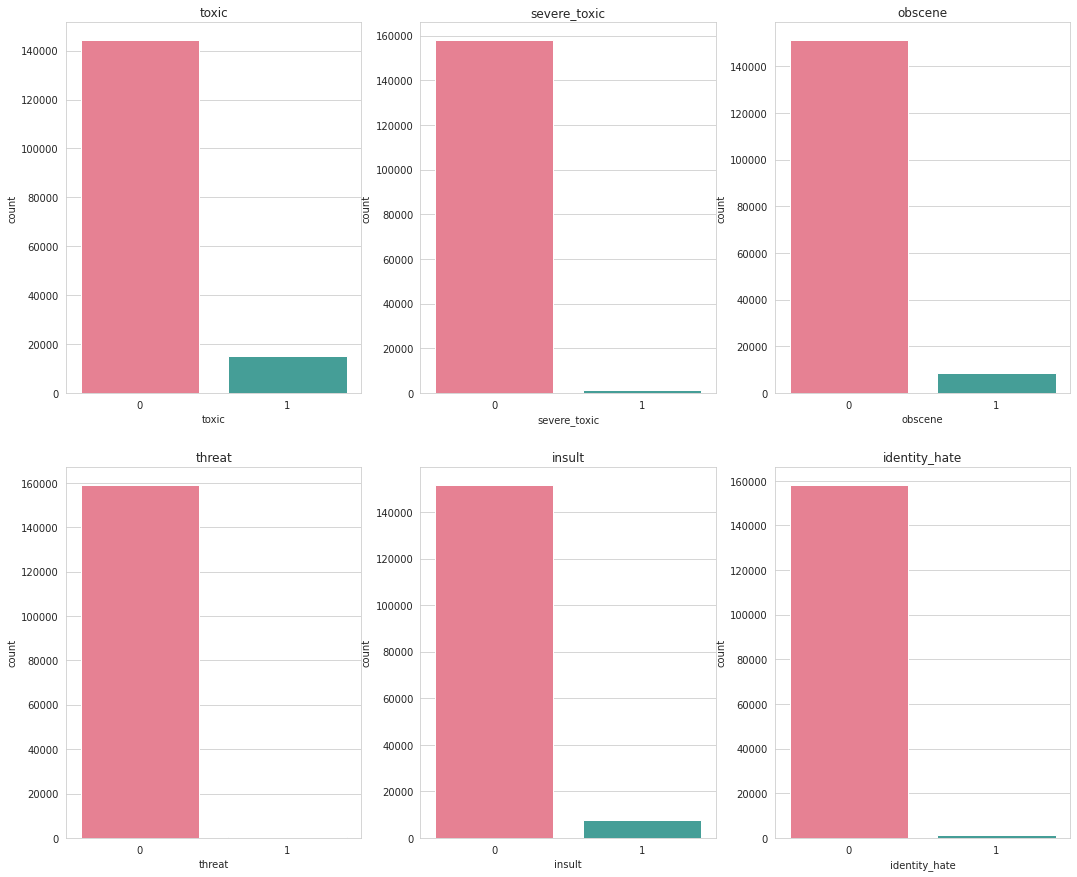

In [24]:
index = 0
fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         figsize=(18, 15))

axes = axes.flatten()
for label in labels:
  sns.countplot(x=label,
                data=train_df,
                ax=axes[index],
                palette="husl")
  axes[index].set_title(label)
  index += 1
plt.show()

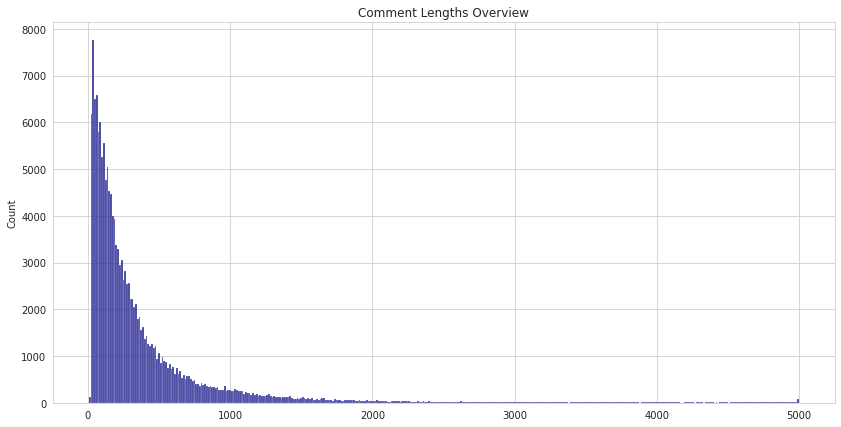

In [25]:
text_lengths = [len(text) for text in train_df["comment_text"]]
fig, ax = plt.subplots(figsize=(14, 7))
sns.histplot(x=text_lengths,
             color="navy").set_title("Comment Lengths Overview")

plt.show()

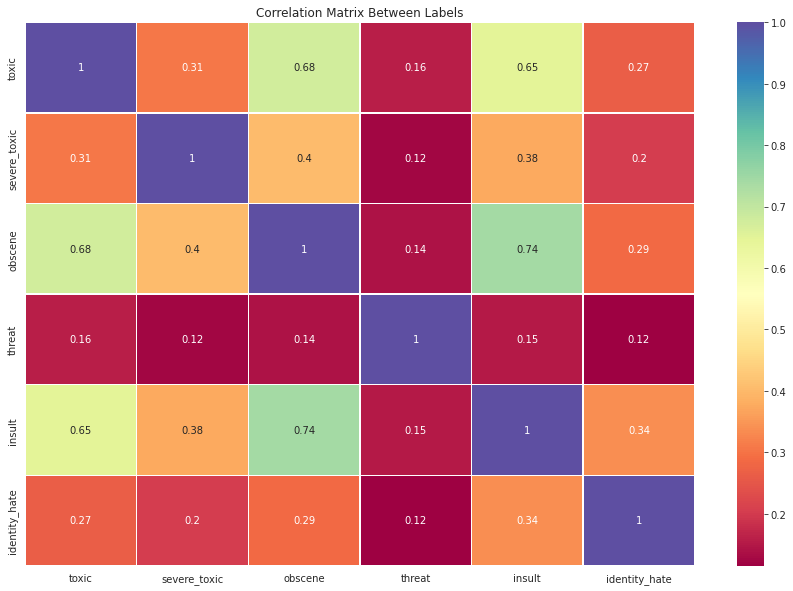

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data=train_df.corr(),
            annot=True,
            linewidths=.5,
            cmap="Spectral",
            ax=ax).set_title("Correlation Matrix Between Labels")

plt.show()

## Classification Model Methodology

In [27]:
def view_comments(df):
  for i in range(0, 5):
    print(i + 1, '-', df["comment_text"][i], end="\n\n")

def clean_comment(comment):
  # Set comment to lowercase
  comment = comment.lower()
  # Remove newlines
  comment = re.sub(r"\n", " ", comment)
  # Remove apostrophes
  comment = re.sub(r"'s", "", comment)
  # Replace "'m" to " am"
  comment = re.sub(r"'m", " am", comment)
  # Replace "'ve" to " have"
  comment = re.sub(r"'ve", " have", comment)
  # Replace "'re" to " are"
  comment = re.sub(r"'re", " are", comment)
  # Replace "'d" to " would"
  comment = re.sub(r"'d", " would", comment)
  # Replace "'ll" to " will"
  comment = re.sub("'ll", " will", comment)
  # Replace "can't" to "can not"
  comment = re.sub(r"can't", "can not", comment)
  # Remove digits but not strings containing digits
  comment = re.sub(r"\b[0-9]+\b\s*", "", comment)
  # Remove duplicate letters
  comment = re.sub(r"(.)\1{2,}", r"\1", comment)
  # Remove strings containing punctuations
  comment = re.sub("[A-Za-z]*[^A-Za-z ]\\S*\\s*", "", comment)
  # Remove punctuations
  comment = re.sub(r"[^\w\s]", "", comment)
  # Remove extra whitespaces
  comment = re.sub(r"\s+", " ", comment)
  # Remove stopwords
  comment = ' '.join([word for word in comment.split() if word not in STOPWORDS])
  # Lemmatize
  wnl = nltk.stem.wordnet.WordNetLemmatizer()
  comment = ' '.join([wnl.lemmatize(word) for word in comment.split()])
  return comment

In [28]:
view_comments(train_df)

1 - Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

2 - D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

3 - Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.

4 - "
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on 

In [29]:
train_df["comment_text"] = train_df["comment_text"].map(lambda x: clean_comment(x))

In [30]:
view_comments(train_df)

1 - explanation edits made username hardcore metallica fan closure gas voted new york doll please remove template talk page retired

2 - match background colour seemingly stuck january

3 - hey really trying edit guy constantly removing relevant information talking edits instead talk seems care formatting actual

4 - make real suggestion improvement wondered section statistic later subsection think reference may need tidying exact format ie date format later first preference formatting style reference want please let appears backlog article review guess may delay reviewer turn listed relevant form eg

5 - chance remember page



In [31]:
X = train_df["comment_text"]
y = train_df[labels]
X.shape, y.shape

((159571,), (159571, 6))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (119678,)
Shape of X_test: (39893,)
Shape of y_train: (119678, 6)
Shape of y_test: (39893, 6)


In [33]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [34]:
X_train.shape, X_test.shape

((119678, 98664), (39893, 98664))

In [35]:
X_train[:5].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
X_test[:5].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(random_state=42)
}

for name, model in models.items():
  avg_accuracy_score = 0
  avg_roc_auc_score = 0
  for label in labels:
    model.fit(X_train, y_train[label])
    y_pred = model.predict(X_test)
    avg_accuracy_score += accuracy_score(y_test[label], y_pred)
    avg_roc_auc_score += roc_auc_score(y_test[label], y_pred)
  print(f"{model}")
  print(f"Accuracy Score: {(avg_accuracy_score/6)*100}%")
  print(f"ROC AUC Score: {(avg_roc_auc_score / 6)*100}%\n")

LogisticRegression()
Accuracy Score: 97.75190300721096%
ROC AUC Score: 65.97109347661525%

RandomForestClassifier(random_state=42)
Accuracy Score: 97.68213303921321%
ROC AUC Score: 63.95275734874295%



## Neural Networks Methodology

In [38]:
train_df = pd.read_csv("/content/jigsaw-toxic-comment-classification-challenge/train.csv", low_memory=False)

In [39]:
X = train_df["comment_text"]
y = train_df[labels]
X.shape, y.shape

((159571,), (159571, 6))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (119678,)
Shape of X_test: (39893,)
Shape of y_train: (119678, 6)
Shape of y_test: (39893, 6)


In [41]:
max_tokens = 200000
max_length = round(sum([len(comment.split()) for comment in train_df["comment_text"]]) / len(train_df))
vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                               output_mode="int",
                                               output_sequence_length=max_length)

In [42]:
vectorizer.adapt(X_train)
vocabulary = vectorizer.get_vocabulary()
most_common_words = vocabulary[:5]
least_common_words = vocabulary[-5:]
print("Number of words in vocabulary:", len(vocabulary))
print("Most common words:", most_common_words)
print("Least common words:", least_common_words)

Number of words in vocabulary: 200000
Most common words: ['', '[UNK]', 'the', 'to', 'of']
Least common words: ['andreaolsen', 'andreafox2', 'andrade', 'andr', 'andorbob']


In [43]:
tf.random.set_seed(42)

embedding_layer = tf.keras.layers.Embedding(input_dim=max_tokens,
                                            output_dim=128,
                                            embeddings_initializer="uniform",
                                            input_length=max_length)

inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = vectorizer(inputs)
x = embedding_layer(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(6, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 67)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 67, 128)           25600000  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 25,699,590
Trainable params: 25,699,590
Non-tra

In [44]:
model_history = model.fit(X_train,
                          y_train,
                          epochs=5,
                          validation_data=(X_test, y_test))

Epoch 1/5
3740/3740 [==============================] - 103s 25ms/step - loss: 0.0641 - accuracy: 0.9877 - val_loss: 0.0499 - val_accuracy: 0.9939
Epoch 2/5
3740/3740 [==============================] - 95s 26ms/step - loss: 0.0409 - accuracy: 0.9928 - val_loss: 0.0496 - val_accuracy: 0.9932
Epoch 3/5
3740/3740 [==============================] - 91s 24ms/step - loss: 0.0311 - accuracy: 0.9865 - val_loss: 0.0525 - val_accuracy: 0.9897
Epoch 4/5
3740/3740 [==============================] - 91s 24ms/step - loss: 0.0230 - accuracy: 0.9312 - val_loss: 0.0584 - val_accuracy: 0.9118
Epoch 5/5
3740/3740 [==============================] - 92s 25ms/step - loss: 0.0165 - accuracy: 0.8565 - val_loss: 0.0657 - val_accuracy: 0.7399


In [45]:
model_pred_proba = model.predict(X_test)
labels_percentage = tf.squeeze(model_pred_proba)
model_preds = tf.squeeze(tf.round(model_pred_proba))
model_preds

1247/1247 [==============================] - 7s 5ms/step


<tf.Tensor: shape=(39893, 6), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [46]:
print(f"Accuracy score: {accuracy_score(y_test, model_preds)*100}%")
print(f"AUC ROC score: {roc_auc_score(y_test, model_preds)*100}%")

Accuracy score: 90.86305868197428%
AUC ROC score: 74.02129524495395%
